In [2]:
!pip install -U sentence-transformers
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 2.2 MB/s eta 0:00:00


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
from sentence_transformers import util

sns.set_context('notebook')
sns.set_style('white')

In [2]:
def plotter(x, y, title):
    plt.plot(x, y)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    plt.show()

In [3]:
sentences = ['This framework generates embeddings for each input sentence',
            'Sentences are passed as a list of string.',
            'The quick brown fox jumps over the lazy dog.']

In [4]:
model = SentenceTransformer('all-MiniLM-L6-v2')

The `.encode` method of the model computes the embeddings of the sentences we pass in. The embeddings returned could be numpy arrays or tensors of **length 384**.


In [5]:
embeddings = model.encode(sentences, convert_to_numpy=True)
embeddings.shape

(3, 384)

We can examine the first 50 values in the embedding vector of the first sentence:


In [6]:
embeddings[0][:50]

array([-0.01371736, -0.04285154, -0.0156286 ,  0.01405373,  0.03955377,
        0.12179628,  0.02943341, -0.03175242,  0.03549596, -0.07931399,
        0.01758787, -0.04043697,  0.04972593,  0.02549122, -0.07187006,
        0.08149689,  0.00147069,  0.0479627 , -0.04503364, -0.09921747,
       -0.02817697,  0.06450461,  0.04446705, -0.0476217 , -0.03529523,
        0.04386718, -0.05285661,  0.00043306,  0.10192151,  0.01640722,
        0.03269966, -0.03459867,  0.01213395,  0.07948708,  0.00458346,
        0.01577778, -0.00968206,  0.02876257, -0.0505806 , -0.01557937,
       -0.02879065, -0.00962281,  0.03155567,  0.0227349 ,  0.08714492,
       -0.03850275, -0.08847184, -0.00875498, -0.02123433,  0.02089232],
      dtype=float32)

## SBERT for Analyzing Semantic Textual Similarity (STS)


We can calculate the similarity scores of the computed embeddings using e.g. cosine similarity to analyze the semantic relationship between sentences.


In [7]:
sentences = ['The cat sits outside',
             'A man is playing guitar',
             'I love pasta',
             'The new movie is awesome',
             'The cat plays in the garden',
             'A woman watches TV',
             'The new movie is so great',
             'Do you like pizza?']

embeddings = model.encode(sentences, convert_to_numpy=True)

Let's define a function for calculating the cosine similarity score.


$$ similarity = \frac{A \cdot B}{||A|| \cdot ||B||} $$


In [8]:
def cosine_similarity(a, b):

    score = np.dot(a, b) / (norm(a) * norm(b))

    return score

The `cosine_similarity` score between "The cat sits outside" and "A man is playing guitar" should be low:


In [9]:
cosine_similarity(embeddings[0], embeddings[1])

0.036330383

The `cosine_similarity` score between "The new movie is awesome" and "The new movie is so great" should be very high:


In [10]:
cosine_similarity(embeddings[3], embeddings[6])

0.89390373

We can use the utility function `cos_sim` to calculate cosine similarity scores for all sentence pairs in `sentences`. Since we have 8 sentence embeddings, the function will return a $8 \times 8$ matrix of the scores.


In [11]:
cosine_scores = util.cos_sim(embeddings, embeddings)
cosine_scores.shape

torch.Size([8, 8])

Let's create a list of the cosine scores of the unique sentence pairs. n sentence embeddings should generate $n(n-1) / 2$ pairs. Thus, 28 unique pairs in our case.


In [14]:
pairs = []

for i in range(len(cosine_scores)-1): # 0, 1, 2, 3, 4, 5, 6
    for j in range(i+1, len(cosine_scores)): # 1-7, 2-7, 3-7, 4-7, 5-7, 6-7, 7
        pairs.append({'index': [i,j], 'score': cosine_scores[i][j]})

len(pairs)

28

We sort the scores in descending order and print 3 sentence pairs with the highest cosine similarity scores.


In [15]:
sorted_pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)

for pair in sorted_pairs[0:3]:
    i, j = pair['index']
    print(f"{sentences[i]} | {sentences[j]} \n Score: {pair['score']:.2f} \n")

The new movie is awesome | The new movie is so great 
 Score: 0.89 

The cat sits outside | The cat plays in the garden 
 Score: 0.68 

I love pasta | Do you like pizza? 
 Score: 0.51 



We can also visualize the distance between the sentences on a 2-dimensional plot. Let's apply PCA to reduce the dimensionality of the sentence embeddings.


In [16]:
pca = PCA(n_components=2)
embeddings_reduced = pca.fit_transform(embeddings)

By examining the plot below, we see that for the sentences that are semantically close to each other, they appear closely on the plot as well.
For example 'The cat sits outside','The cat plays in the garden' are near and 'I love pasta'  and   'Do you like pizza?' make up a cluster.


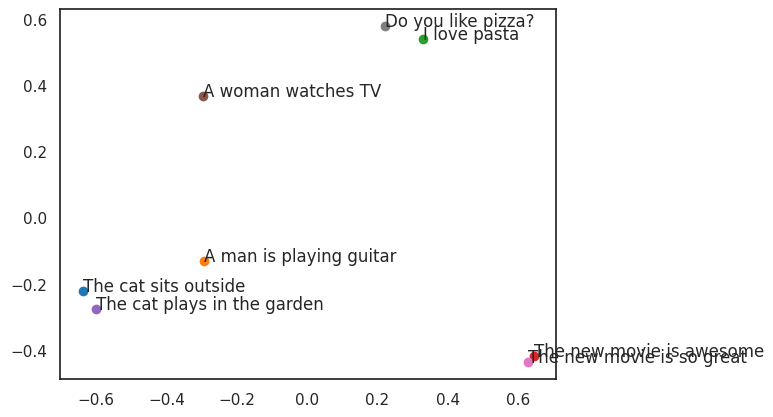

In [17]:
for coord, sentence in zip(embeddings_reduced, sentences):

    plt.scatter(coord[0], coord[1])
    plt.annotate(sentence, (coord[0], coord[1]))

## Recommendation SBERT Embeddings


In this section, we will apply SBERT on a dataset that contains the descriptions and notes of more than 8000 different Courses.  SBERT will help us translate that into sentence embeddings which can be numerically manipulated.

### Preprocessing the Dataset


In [40]:
df = pd.read_csv("courses.csv", encoding="unicode_escape")
df.head()

,ï»¿CourseId,CourseTitle,DurationInSeconds,ReleaseDate,Description,AssessmentStatus,IsCourseRetired
0,abts-advanced-topics,BizTalk 2006 Business Process Management,22198,2008-10-25,This course covers Business Process Management...,Live,no
1,abts-fundamentals,BizTalk 2006 Fundamentals,24305,2008-06-01,Despite the trend towards service-oriented arc...,Live,no
2,agile-team-practice-fundamentals,Agile Team Practices with Scrum,13504,2010-04-15,This course is much different than most of the...,Live,no
3,appsrv-fundamentals,Windows Server AppFabric Fundamentals,0,2000-01-01,NaN,None,yes
4,aspdotnet-advanced-topics,ASP.NET 3.5 Advanced Topics,21611,2008-12-05,This course covers more advanced topics in ASP...,Live,no


In [30]:
list(df.CourseTitle[0:10])

['BizTalk 2006 Business Process Management',
 'BizTalk 2006 Fundamentals',
 'Agile Team Practices with Scrum',
 'Windows Server AppFabric Fundamentals',
 'ASP.NET 3.5 Advanced Topics',
 'ASP.NET Ajax Advanced Topics',
 'ASP.NET Ajax Fundamentals',
 'ASP.NET Ajax JavaScript and jQuery',
 'ASP.NET 3.5 Working With Data',
 'ASP.NET 3.5 Fundamentals']

:We want the text embeddings to be generated based on the **CourseTitle** column. Thus, we remove redundant columns and organize the data frame.


In [31]:
df.rename(columns={"ï»¿CourseId": "CourseId"}, inplace=True)
df['CourseTitle'] = df['CourseId'] + " - " + df['CourseTitle']
df.drop(labels=['DurationInSeconds', 'ReleaseDate', 'AssessmentStatus','IsCourseRetired', 'CourseId'], axis=1, inplace=True)
df.head()

,CourseTitle,Description
0,abts-advanced-topics - BizTalk 2006 Business P...,This course covers Business Process Management...
1,abts-fundamentals - BizTalk 2006 Fundamentals,Despite the trend towards service-oriented arc...
2,agile-team-practice-fundamentals - Agile Team ...,This course is much different than most of the...
3,appsrv-fundamentals - Windows Server AppFabric...,NaN
4,aspdotnet-advanced-topics - ASP.NET 3.5 Advanc...,This course covers more advanced topics in ASP...


Check for missing values.


In [32]:
df.CourseTitle.isnull().sum()

0

Drop the rows with missing values and reset the indices.


In [33]:

df=df[0:1000]
df.dropna(inplace = True)
df.reset_index(inplace=True, drop = True)
df.shape

(995, 2)

After the preprocessing, we now have 995 perfumes in the data frame.
After trying to run with the complete dataset of over 8000 lines we faced resource and run time issues so we down sized to 1000 to be able to experiment and validate the model



### Creating Embeddings


Let's start by putting the titles into a list.


In [34]:
df.CourseTitle = df.CourseTitle.apply(lambda x: str(x))
notes = df.CourseTitle.to_list()
len(notes)

995

We use the `all-MiniLM-L6-v2` pre-trained SBERT model to generate the sentence embeddings of the perfume notes.


In [35]:
model = SentenceTransformer('all-MiniLM-L6-v2')

note_embeddings = model.encode(notes, show_progress_bar=True, batch_size=64)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

We check that each generated note embedding has length 384.


In [41]:
print(note_embeddings.shape)

print(note_embeddings[0][:50]) # first 50 values in the embedding

(995, 384)
[-0.01515076 -0.00695352 -0.01890821 -0.01249928 -0.04343986 -0.00070237
  0.10794567  0.03372328 -0.01546355  0.04150046 -0.0852464   0.03584457
  0.00471251 -0.00476881  0.04159798  0.06578822  0.06985239 -0.11378729
 -0.00340471 -0.02320818  0.0049405   0.03169927 -0.00892626  0.03950895
 -0.11411214 -0.04867205  0.02858972  0.01898314  0.05028529 -0.0444911
  0.00053417  0.12408435  0.06621706  0.02066118  0.01624344  0.01723964
  0.00520709  0.00082156  0.03627277 -0.00100756  0.01556972  0.00550248
 -0.05762155 -0.0315439   0.02598387 -0.03683918 -0.08893823 -0.05827235
 -0.10143003  0.06551579]


### Recommendation using Cosine Similarity


We calculate the cosine similarity scores for all the pairs of perfume note embeddings.


In [37]:
cosine_scores = util.cos_sim(note_embeddings, note_embeddings)
cosine_scores.shape

torch.Size([995, 995])

Sorting the scores in descending order and appending the (index, score) pair to `pairs`.


In [38]:
pairs = []

for i in range(len(cosine_scores)-1):
    for j in range(i+1, len(cosine_scores)):
        pairs.append({"index": [i,j], "score": cosine_scores[i][j]})

len(pairs)

494515

In [39]:
sorted_pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)

for pair in sorted_pairs[0:10]:
    i, j = pair['index']
    print(f"{df.iloc[i, 0]} | {df.iloc[j, 0]} \n Score: {pair['score']:.2f} \n")

adv-win-debug-part-1 - Advanced Windows Debugging - Part 1 | adv-win-debug-part-2 - Advanced Windows Debugging - Part 2 
 Score: 1.00 

vs2012-intro-part1 - Introduction to Visual Studio 2012 - Part 1 | vs2012-intro-part2 - Introduction to Visual Studio 2012 - Part 2 
 Score: 0.99 

mastering-java-swing-part1 - Mastering Java Swing - Part 1 | mastering-java-swing-part2 - Mastering Java Swing - Part 2 
 Score: 0.99 

mastering-java-swing-part2 - Mastering Java Swing - Part 2 | mastering-java-swing-part4 - Mastering Java Swing - Part 4 
 Score: 0.99 

cpt-sp2007-dev-ramp-part1 - SharePoint 2007 Developer Ramp-Up - Part 1 | cpt-sp2007-dev-ramp-part2 - SharePoint 2007 Developer Ramp-Up - Part 2 
 Score: 0.99 

mastering-java-swing-part3 - Mastering Java Swing - Part 3 | mastering-java-swing-part4 - Mastering Java Swing - Part 4 
 Score: 0.99 

mastering-java-swing-part1 - Mastering Java Swing - Part 1 | mastering-java-swing-part4 - Mastering Java Swing - Part 4 
 Score: 0.99 

mastering-ja